# Showcase how to run and plot a simulation of virtual Argo floats

Here only trajectories are looked at, not measurements collected by floats.

The deployment is taken from the real Argo array using [argopy](http://github.com/euroargodev/argopy)

If you run this notebook on Binder, velocity data have automatically been downloaded.

The velocity fields used is from the 1/12 Mercator forecast ([GLOBAL-ANALYSIS-FORECAST-PHY-001-024](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024)).

This notebook is for demonstration purposes only, so the velocity field is limited to the 1st day of each 2019 months (i.e. 12 fields).

***
Script prepared by [K Balem](http://github.com/quai20) andf [G Maze](http://github.com/gmaze) (Jun. 2020)

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [1]:
import sys
import numpy as np
import xarray as xr
import pandas as pd

sys.path.insert(0, "..") # This is while waiting for the pypi integration
import virtualargofleet as vaf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

# Set-up the velocity field

In [2]:
# Set how to find the velocity field
# src = "/home/datawork-lops-oh/somovar/WP1/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024" # Datarmor
# src = "/Users/gmaze/data/MERCATOR/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024" # Laptop
src = "/home/jovyan/data" # Binder

filenames = {'U': src + "/2019*.nc",
             'V': src + "/2019*.nc"}
variables = {'U':'uo','V':'vo'}
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

In [3]:
# Ddefine the velocity field object of the VF:
# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1) 
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

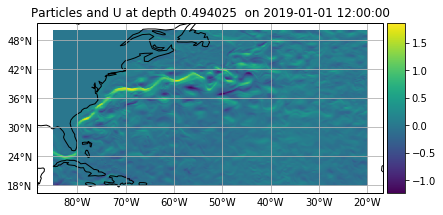

In [4]:
VELfield.plot()

# Define a deployment plan of virtual Argo floats

We use [argopy](https://github.com/euroargodev/argopy) to download the real Argo array deployments in the region.


In [5]:
sys.path.insert(0, "../../argopy") # This is only on my lpatopn, it's already installed on binder
import argopy
print(argopy.__version__)

from argopy import DataFetcher as ArgoDataFetcher
# from argopy import IndexFetcher as ArgoIndexFetcher

999


In [6]:
ds = ArgoDataFetcher(cache=1, mode='expert').region([-80, -30, 20, 48, 0, 100, '2019-01', '2020-01']).to_xarray()
ds_plan = ds.where(ds['CYCLE_NUMBER']==1, drop=True).argo.point2profile()
ds_plan = ds_plan.where(ds_plan['N_LEVELS']==0, drop=1).squeeze()
ds_plan = ds_plan.where(ds_plan['DIRECTION']=='A', drop=1)

In [7]:
print(ds_plan)

<xarray.Dataset>
Dimensions:              (N_PROF: 27)
Coordinates:
    TIME                 (N_PROF) datetime64[ns] 2019-02-12T11:41:20 ... 2019-12-02T04:55:00
    LATITUDE             (N_PROF) float64 28.53 23.01 21.61 ... 47.0 42.21 42.17
  * N_PROF               (N_PROF) int64 29 30 31 20 26 25 ... 27 28 11 12 13 14
    N_LEVELS             int64 0
    LONGITUDE            (N_PROF) float64 -53.95 -61.92 -63.94 ... -48.37 -48.32
Data variables:
    CYCLE_NUMBER         (N_PROF) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    DATA_MODE            (N_PROF) object 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION            (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER      (N_PROF) float64 6.903e+06 6.903e+06 ... 4.902e+06
    POSITION_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES                 (N_PROF) float32 3.8 2.9 2.8 1.08 ... 0.4 1.4 10.4 2.4
    PRES_ADJUSTED        (N_PROF) float32 nan nan nan nan ... nan nan nan 

In [8]:
# WMO of floats deployed in the region:
np.unique(ds_plan['PLATFORM_NUMBER'])

array([4902467., 4902470., 4902496., 4902497., 4902498., 4902499.,
       4903044., 4903050., 4903051., 4903054., 4903055., 4903056.,
       4903213., 4903214., 4903216., 4903218., 4903219., 4903220.,
       4903244., 4903260., 6902914., 6902915., 6902916., 7900526.,
       7900527., 7900528., 7900529.])

In [9]:
ds_traj = []
for wmo in ds_plan['PLATFORM_NUMBER']:
    ds_traj.append(ds.where(ds['PLATFORM_NUMBER']==wmo, drop=1).drop_vars(['N_LEVELS', 'N_PROF']))
ds_traj = xr.concat(ds_traj, dim='N_POINTS')
ds_traj = ds_traj.argo.point2profile()
ds_traj

<xarray.Dataset>
Dimensions:              (N_LEVELS: 100, N_PROF: 609)
Coordinates:
    TIME                 (N_PROF) datetime64[ns] 2019-02-10T06:52:00 ... 2019-12-31T13:07:03
    LATITUDE             (N_PROF) float64 28.56 23.03 28.53 ... 20.73 39.17
  * N_PROF               (N_PROF) int64 6 5 458 4 491 524 ... 64 68 523 556 457
  * N_LEVELS             (N_LEVELS) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
    LONGITUDE            (N_PROF) float64 -53.99 -61.99 -53.95 ... -62.15 -71.65
Data variables:
    CYCLE_NUMBER         (N_PROF) int64 1 1 1 1 1 1 2 2 ... 33 32 32 4 4 33 33 6
    DATA_MODE            (N_PROF) <U1 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION            (N_PROF) <U1 'D' 'D' 'A' 'D' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER      (N_PROF) int64 6902914 6902915 ... 6902916 4903260
    POSITION_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES                 (N_PROF, N_LEVELS) float32 5.2 6.3 8.3 ... nan nan nan
    PRES_ADJUSTED        (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    PRES_ADJUSTED_ERROR  (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    PRES_ADJUSTED_QC     (N_PROF) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    PRES_QC              (N_PROF, N_LEVELS) int64 1 1 ... -9223372036854775808
    PSAL                 (N_PROF, N_LEVELS) float32 37.219 37.218 ... nan nan
    PSAL_ADJUSTED        (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    PSAL_ADJUSTED_ERROR  (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    PSAL_ADJUSTED_QC     (N_PROF) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    PSAL_QC              (N_PROF, N_LEVELS) int64 1 1 ... -9223372036854775808
    TEMP                 (N_PROF, N_LEVELS) float32 23.542 23.543 ... nan nan
    TEMP_ADJUSTED        (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    TEMP_ADJUSTED_ERROR  (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan nan
    TEMP_ADJUSTED_QC     (N_PROF) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    TEMP_QC              (N_PROF, N_LEVELS) int64 1 1 ... -9223372036854775808
    TIME_QC              (N_PROF) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/06/29
    Fetched_constraints:  phy_[x=-80.00/-30.00; y=20.00/48.00; z=0.0/100.0; t...
    Fetched_uri:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.nc...
    history:              Transformed with point2profile

In [10]:
VFleet = vaf.virtualfleet(lat=ds_plan['LATITUDE'], lon=ds_plan['LONGITUDE'], depth=ds_plan['PRES'], time=ds_plan['TIME'], vfield=VELfield)

## Show deployment plan

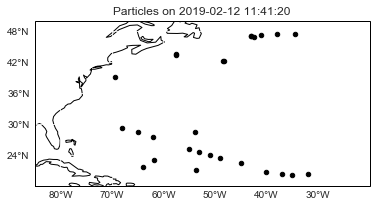

In [11]:
VFleet.plotfloat()

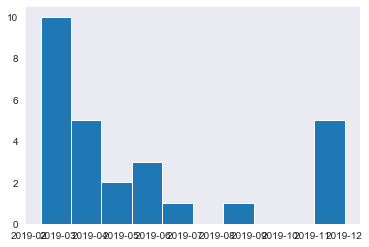

In [12]:
plt.hist(VFleet.time);

# Run the virtual fleet simulation

In [13]:
%%time
# Define where to store results
run_outputs = "out"
output_file = run_outputs + '/test_%s.nc' % pd.to_datetime('now').strftime("%Y%m%d%H%M%S")
# output_file = run_outputs + '/test_20200629131707.nc'

# Run it:
VFleet.simulate(duration=365, dt_run=1, dt_out=1./2, output_file=output_file)

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/parcels-22325/b9380b9279837d9f6b2b3da7351c54e7_0.so
INFO: Temporary output files are stored in out/out-BDYGSPEN.
INFO: You can use "parcels_convert_npydir_to_netcdf out/out-BDYGSPEN" to convert these to a NetCDF file during the run.


Particle deleted on boundary


Particle deleted on boundary


Particle deleted on boundary


100% |########################################################################|


CPU times: user 7min 7s, sys: 21.4 s, total: 7min 28s
Wall time: 7min 32s


# Plot the virtual fleet simulation results

In [20]:
# Load simulation results:
simu = xr.open_dataset(output_file)
print(simu)

<xarray.Dataset>
Dimensions:      (obs: 17521, traj: 27)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev45+g00953f31
    parcels_mesh:           spherical


In [21]:
# ID virtual floats to their real WMO:

print(np.unique(ds_plan['PLATFORM_NUMBER']))
simu['PLATFORM_NUMBER'] = xr.DataArray(np.full((len(simu['traj']),), 0), dims='traj')
wmos = []

x_real = np.round(ds_traj['LONGITUDE'], 5).values
y_real = np.round(ds_traj['LATITUDE'], 5).values
for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    x_virt = np.round(this.sel(obs=0)['lon'], 3).values
    y_virt = np.round(this.sel(obs=0)['lat'], 3).values
    ii = np.argmin(np.sqrt(np.power(x_real-x_virt,2) + np.power(y_real-y_virt,2)))
    wmo = np.array((ds_traj.isel(N_PROF=ii)['PLATFORM_NUMBER'].values,))[0]
    wmos.append(wmo)
#     print(wmo)
simu['PLATFORM_NUMBER'].values = wmos

[4902467. 4902470. 4902496. 4902497. 4902498. 4902499. 4903044. 4903050.
 4903051. 4903054. 4903055. 4903056. 4903213. 4903214. 4903216. 4903218.
 4903219. 4903220. 4903244. 4903260. 6902914. 6902915. 6902916. 7900526.
 7900527. 7900528. 7900529.]


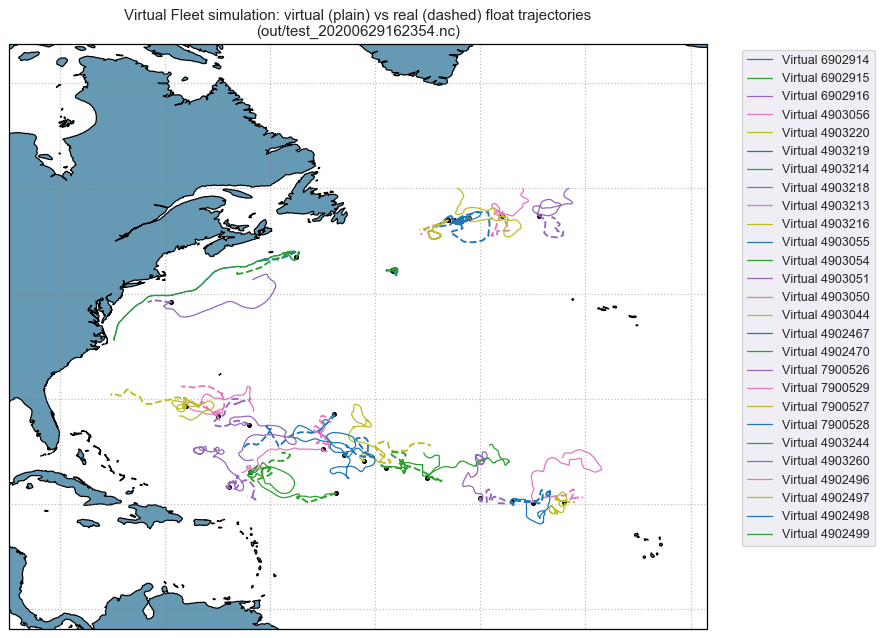

In [24]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

pr1 = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10), dpi=90)
ax3 = fig.add_subplot(1,1,1, projection=pr1)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-10, simu.lon.max()+10, simu.lat.min()-10, simu.lat.max()+10])
# ax3.set_extent([simu.lon.min()-10, simu.lon.max()+10, simu.lat.min()-10, 35])

gl = ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

# And velocity field to superimpose on plot (SLA):
if False:
    velo = xr.open_dataset(src + '/20200627_global-analysis-forecast-phy-001-024.nc')
    velo['zos'][0][:][:].plot(cmap=plt.cm.coolwarm,
                              cbar_kwargs={'orientation': 'horizontal', 'shrink':0.5, 'pad':0.1},
                              transform=pr1)

for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    ax3.plot(this['lon'][0], this['lat'][0],'k.', transform=pr1)
    pp_virt = ax3.plot(this['lon'], this['lat'], linewidth=1, transform=pr1, label="Virtual %s" % str(this['PLATFORM_NUMBER'].values))
    wmo = this['PLATFORM_NUMBER'].values
    this = ds_traj.where(ds_traj['PLATFORM_NUMBER']==wmo, drop=1)
    pp_real = ax3.plot(this['LONGITUDE'], this['LATITUDE'], '--')
#     pp_real = ax3.plot(this['LONGITUDE'], this['LATITUDE'], '--', label="Real %s" % str(wmo))
    plt.setp(pp_real[0], 'color', plt.getp(pp_virt[0], 'color'))

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title("Virtual Fleet simulation: virtual (plain) vs real (dashed) float trajectories\n(%s)" % output_file);

In [29]:
trj = simu.isel(traj=0)
# trj = simu.isel(traj=nfloats-1)
# trj = simu.where(simu['PLATFORM_NUMBER']==4903260, drop=1)
# trj = simu.where(simu['PLATFORM_NUMBER']==4903051, drop=1)

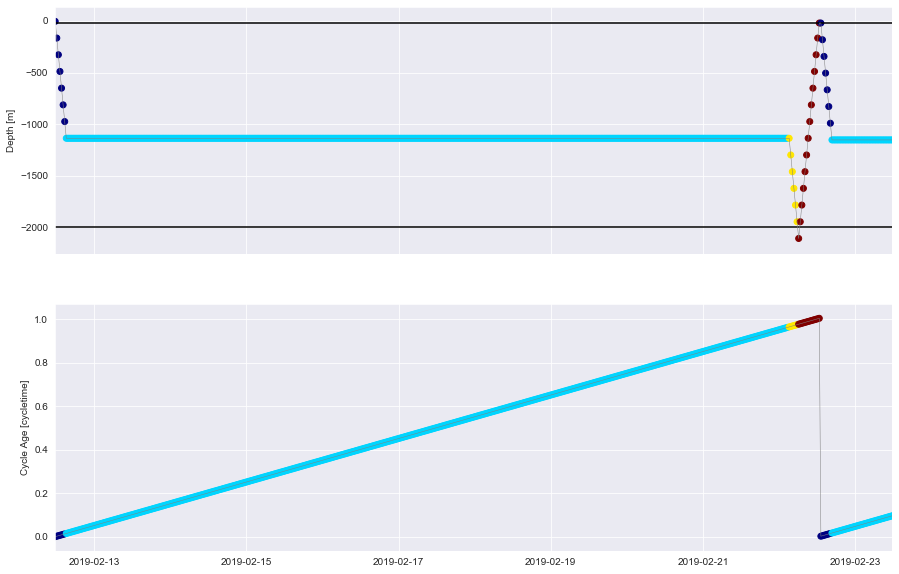

In [30]:
cycletime = 10 * 86400  # in s

dpt = trj['z']
y = trj['cycle_age']/cycletime
# y = trj['cycle_age']
# x = np.arange(0, len(y))
x = trj['time'].values

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
ax = ax.flatten()

ax[0].plot(x, -dpt, 'gray', linewidth=0.5)
sc = ax[0].scatter(x, -dpt, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[0].grid()
ax[0].set_ylabel('Depth [m]')
ax[0].hlines(-20,x[0], x[-1])
ax[0].hlines(-2000,x[0], x[-1])

ax[1].plot(x, y, 'gray', linewidth=0.5)
sc = ax[1].scatter(x, y, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[1].set_ylabel('Cycle Age [cycletime]')
ax[1].grid()

# Only display the first float cycle
[i.set_xlim(x[0], x[int((cycletime/86400+1)*24/VFleet.run_params['dt_out'])]) for i in ax];

In [31]:
for i in simu['traj']:
    ds = simu.sel(traj=i)
    print(ds['PLATFORM_NUMBER'].values, " launched on :", ds['time'][0].values)

6902914  launched on : 2019-02-12T11:41:20.000000000
6902915  launched on : 2019-02-14T11:43:20.000000000
6902916  launched on : 2019-02-14T11:51:20.000000000
4903056  launched on : 2019-03-07T10:32:37.000000000
4903220  launched on : 2019-03-08T06:35:03.000000000
4903219  launched on : 2019-03-08T10:34:33.000000000
4903214  launched on : 2019-03-08T19:34:52.000000000
4903218  launched on : 2019-03-10T15:41:50.000000000
4903213  launched on : 2019-03-12T21:36:14.000000000
4903216  launched on : 2019-03-12T22:27:18.000000000
4903055  launched on : 2019-03-22T01:10:33.000000000
4903054  launched on : 2019-03-23T14:29:26.000000000
4903051  launched on : 2019-03-26T19:06:01.000000000
4903050  launched on : 2019-03-27T08:33:43.000000000
4903044  launched on : 2019-03-27T21:57:25.000000000
4902467  launched on : 2019-04-23T04:18:00.000000000
4902470  launched on : 2019-04-23T04:23:00.000000000
7900526  launched on : 2019-06-07T05:37:20.000000000
7900529  launched on : 2019-06-08T05:42:20.000